# DSKUS Group 1 EDA
## Names below

| Dataset Name                        | Source                                      | Time Period       | Size       | Description                                                                                                                                                                                                                              |
|-------------------------------------|---------------------------------------------|-------------------|------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| GCP Fossil CO₂ Emissions Dataset    | [Global Carbon Project (GCP)](https://zenodo.org/record/5569235)                 | 1751 - 2021       | Unknown    | Comprehensive global and national CO₂ emissions data since 2001; includes data on CO₂ emissions from various sources, such as coal, oil, gas, cement, flaring, and other sources.                                                        |
| Climate Watch Dataset               | [International Energy Agency (IEA), U.S. Environmental Protection Agency, U.N. Food and Agriculture Organization, Global Carbon Project](https://www.climatewatchdata.org)   | 1990 - 2019       | Unknown    | Covers all sectors and gases, including energy sub-sectors and Kyoto GHGs (CH4, CO2, N2O, F-gases); does not use countries' official inventories reported to the UNFCCC.                                                                |
| CO₂ Emission Dataset from Kaggle    | International Energy Agency (IEA) and United Nations Framework Convention on Climate Change (UNFCCC) | 1960 - 2020       | Unknown    | Provides a comprehensive overview of the amount of CO₂ emitted by each country; includes information on CO₂ emissions by country from 1960 to 2020; covers all countries in the world and is compiled from various sources.              |


In [35]:
# Installing packages
# Use pip to for installation
#pandas
#matplotlib
#seaborn
#numpy
#plotly
#scipy

In [62]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import warnings
from scipy import interpolate

warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None)

In [53]:
# reading the dataframes
emission = pd.read_csv('../Datasets/emission_by_country.csv')  # GCP Fossil CO₂ Emissions Dataset
ghg = pd.read_csv('../Datasets/ghg-emissions.csv', skipfooter=2)  # Climate Watch Dataset
cont_consump = pd.read_csv("../Datasets/Continent_Consumption_TWH.csv")
country_consump = pd.read_csv("../Datasets/Country_Consumption_TWH.csv")
nonre_eng = pd.read_csv("../Datasets/nonRenewablesTotalPowerGeneration.csv")
re_eng_gen_90_17 = pd.read_csv("../Datasets/renewablePowerGeneration97-17.csv")
re_eng_tot_gen = pd.read_csv("../Datasets/renewablesTotalPowerGeneration.csv")
re_eng_countries = pd.read_csv("../Datasets/top20CountriesPowerGeneration.csv")
ren_gen = pd.read_csv("../Datasets/USA_Ren_Gen.csv") 
co2_df = pd.read_csv('../Datasets/World_CO2_emission.csv')

#### Data Cleaning

We will do the data cleaning first, individually on each dataset in the order as above while importing them.

In [54]:
# emission dataset
# filtering out the rows after 2000
ems = emission[emission['Year'] > 2000].reset_index(drop=True)

# removing rows with null values in the ISO 3166-1 alpha-3 column
rows_to_remove = ems[ems['ISO 3166-1 alpha-3'].isna()]['Country'].unique().tolist()
ems = ems[~ems['Country'].isin(rows_to_remove)]

# Define the list of columns to check for null values
columns_to_check = ['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']
# Remove rows where the specified columns have null values
ems.dropna(subset=columns_to_check, how='all', inplace=True)

In [55]:
ems[ems.Country=='Global'].head()

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
4851,Global,WLD,2001,25668.048326,9255.256797,10390.668975,4773.584851,754.331663,281.128017,213.078023,4.119578
4852,Global,WLD,2002,26281.037468,9678.959137,10385.864180,4905.853640,796.052479,298.553835,215.754196,4.163394
4853,Global,WLD,2003,27651.596453,10518.463642,10679.654448,5081.468111,852.252693,299.375515,220.382043,4.324685
4854,Global,WLD,2004,28636.695037,10871.584335,11042.504634,5257.190057,910.566319,323.802545,231.047147,4.422142
4855,Global,WLD,2005,29614.602256,11543.334878,11139.399176,5380.665522,964.306101,345.094230,241.802350,4.515677


In [56]:
# leaving out the global row as it is the total of all the countries
ems = ems[~ems['Country'].isin(['Global'])]
# we could see the total emission in the global row as above
ems.groupby('Year')[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']].sum().reset_index().head()

,Year,Coal,Oil,Gas,Cement,Flaring,Other
0,2001,9255.256798,10390.668974,4773.584850,754.331664,281.128018,213.078025
1,2002,9678.959137,10385.864176,4905.853641,796.052479,298.553838,215.754198
2,2003,10518.463643,10679.654450,5081.468111,852.252690,299.375519,220.382040
3,2004,10871.584333,11042.504634,5257.190056,910.566322,323.802542,231.047146
4,2005,11543.334876,11139.399176,5380.665520,964.306102,345.094230,241.802353


In [57]:
# cont_consump, country_consump, nonre_eng, re_eng_gen_90_17, re_eng_tot_gen, re_eng_countries datasets
# Change the data type of 'Year' to int and drop the NaN value
country_consump = country_consump.dropna()
country_consump['Year'] = country_consump['Year'].astype(int)
cont_consump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           31 non-null     int64  
 1   World          31 non-null     float64
 2   OECD           31 non-null     float64
 3   BRICS          31 non-null     float64
 4   Europe         31 non-null     float64
 5   North America  31 non-null     float64
 6   Latin America  31 non-null     float64
 7   Asia           31 non-null     float64
 8   Pacific        31 non-null     float64
 9   Africa         31 non-null     float64
 10  Middle-East    31 non-null     float64
 11  CIS            31 non-null     float64
dtypes: float64(11), int64(1)
memory usage: 3.0 KB


In [58]:
# Find indices of NaN values and drop them in the country_consump dataset
country_consump.isna().to_numpy().nonzero()
country_consump.dropna(inplace=True)
# Rename columns in the country_consump dataset to replace spaces with periods
country_consump.rename(columns={"Saudi Arabia": "Saudi.Arabia",
                                "United Kingdom": "United.Kingdom",
                                "United States": "United.States",
                                "New Zealand": "New.Zealand",
                                "South Africa": "South.Africa",
                                "South Korea": "South.Korea",
                                "United Arab Emirates": "United.Arab.Emirates"}, inplace=True)
country_consump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  31 non-null     int64  
 1   China                 31 non-null     float64
 2   United.States         31 non-null     float64
 3   Brazil                31 non-null     float64
 4   Belgium               31 non-null     float64
 5   Czechia               31 non-null     float64
 6   France                31 non-null     float64
 7   Germany               31 non-null     float64
 8   Italy                 31 non-null     float64
 9   Netherlands           31 non-null     float64
 10  Poland                31 non-null     float64
 11  Portugal              31 non-null     float64
 12  Romania               31 non-null     float64
 13  Spain                 31 non-null     float64
 14  Sweden                31 non-null     float64
 15  United.Kingdom        31 

In [59]:
# Drop rows with NaN values in the nonre_eng dataset
nonre_eng.dropna(inplace=True)

# Rename columns in the nonre_eng dataset for clarity and brevity
nonre_eng.rename(columns={"Coal (incl. Peat)": "Coal",
                          "Petroleum and Other Liquids": "Petroleum",
                          "Nuclear": "Nuclear Energy",
                          "Natural Gas": "Natural Gas (Excluding Supplemental Gaseous Fuels)",
                          "Other": "Other Nonrenewable Energy"}, inplace=True)
nonre_eng.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mode of Generation  8 non-null      object 
 1   Contribution (TWh)  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


In [60]:
# ren_gen, co2_df datasets
# Drop the unnecessary 'Unnamed: 0' column from the ren_gen dataset
ren_gen.drop(columns="Unnamed: 0", inplace=True)

# Create a new 'Date' column from the 'YEAR' and 'MONTH' columns, then set it as the index
ren_gen["Date"] = pd.to_datetime(dict(year=ren_gen["YEAR"], month=ren_gen["MONTH"], day=1))
ren_gen = ren_gen.set_index("Date")

# Drop the now redundant 'YEAR' and 'MONTH' columns from the ren_gen dataset
ren_gen.drop(columns=["YEAR", "MONTH"], inplace=True)


In [61]:
# Filter the ren_gen dataset to get the total generation data for the US
total_gen = ren_gen[ren_gen["STATE"] == "US-TOTAL"]

# Filter out rows with 'Total Electric Power Industry' and 'Total' energy sources
total_gen = total_gen[(total_gen["TYPE OF PRODUCER"] != "Total Electric Power Industry") &
                      (total_gen["ENERGY SOURCE"] != "Total")]

# Group and sum the data by 'Date' and 'TYPE OF PRODUCER', then convert the generation to TWh
plot1 = total_gen.groupby(by=["Date", "TYPE OF PRODUCER"]).sum().reset_index()
plot1["Generation (TWh)"] = plot1["GENERATION (Megawatthours)"] / 1000000

# Group and sum the data by 'Date' and 'ENERGY SOURCE', then convert the generation to TWh
plot2 = total_gen.groupby(by=["Date", "ENERGY SOURCE"]).sum().reset_index()
plot2["Generation (TWh)"] = plot2["GENERATION (Megawatthours)"] / 1000000

# Calculate the total generation by energy source and sort the results in descending order
significant = plot2.groupby(by="ENERGY SOURCE").sum()["Generation (TWh)"].reset_index()
total_generation = significant.sort_values("Generation (TWh)", ascending=False)


### Exploratory Data Analysis
 &emsp; In this section, we will explore the datasets using different kinds of plots such as bar charts, line charts, etc. In addition to that, we will provide a brief explanation of each plot right below.

#### Comparison of contribution to CO2 emission by different fuel types over the years (2001-2021)

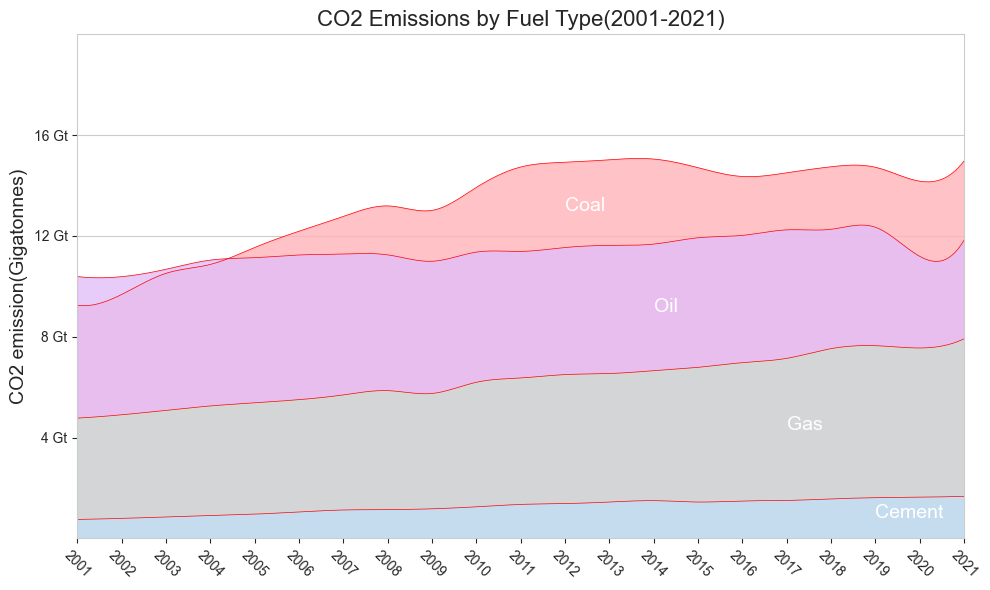

In [63]:
# Prepare the data
emissions_by_fuel_type = ems.groupby('Year')[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']].sum().reset_index()

# Set up the plot
sns.set_style('whitegrid', {'axes.grid': False, 'axes.grid.axis': 'y', 'xtick.bottom': True, 'ytick.left': True})
fig, ax = plt.subplots(figsize=(10, 6))

# Define a function to plot smooth area curves with black boundary lines
def plot_smooth_area_curve(years, values, color, label, alpha):
    x_smooth = np.linspace(years.min(), years.max(), 300)
    y_smooth = interpolate.interp1d(years, values, kind='cubic')(x_smooth)
    ax.fill_between(x_smooth, y_smooth, color=color, label=label, alpha=alpha)
    ax.plot(x_smooth, y_smooth, color='red', linewidth=0.5)

# Plot the data
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Coal'], '#FFB3BA', 'Coal', 0.8)
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Oil'], '#E2BEF8', 'Oil', 0.8)
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Gas'], '#C8E6C9', 'Gas', 0.6)
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Cement'], '#BAE1FF', 'Cement', 0.6)

# Customize the plot
ax.set_xticks(emissions_by_fuel_type['Year'])
ax.set_xticklabels(emissions_by_fuel_type['Year'], rotation=-45)

# Set the x-axis limits to the minimum and maximum years
ax.set_xlim(emissions_by_fuel_type['Year'].min(), emissions_by_fuel_type['Year'].max())

ax.set_yticks([4e3, 8e3, 12e3, 16e3])
ax.set_yticklabels(['4 Gt', '8 Gt', '12 Gt', '16 Gt'])
ax.set_ylim(0, 20e3)
ax.set_ylabel('CO2 emission(Gigatonnes)', fontsize=14)

# Add text annotations
ax.text(2012, 13e3, 'Coal', color='white', size=14)
ax.text(2014, 9e3, 'Oil', color='white', size=14)
ax.text(2017, 4.3e3, 'Gas', color='white', size=14)
ax.text(2019, 0.8e3, 'Cement', color='white', size=14)

# Set the horizontal grid
plt.grid(axis='y')
plt.title('CO2 Emissions by Fuel Type(2001-2021)', fontsize=16)
plt.tight_layout()
plt.show()


&emsp; The plot provides a visual representation of **carbon dioxide emissions (in gigatonnes)** from various fuel sources over a **20-year period from 2001 to 2021**. The data reveals a general **upward trend** in emissions across most fuel sources, with **coal** being the **highest emitter**, followed by **oil** and **gas**. 

&emsp; Interestingly, there was a **downward trend in the year 2019** significantly impacted by the **coronavirus pandemic**, during which many countries imposed lockdowns to contain the virus, resulting in restricted industrial activities. 

&emsp; Although most sources show an upward trend in CO2 emissions over the years, the **cement industry** shows a relatively **stable trend** compared to the others.


#### Comparison of energy consumption for economic associations

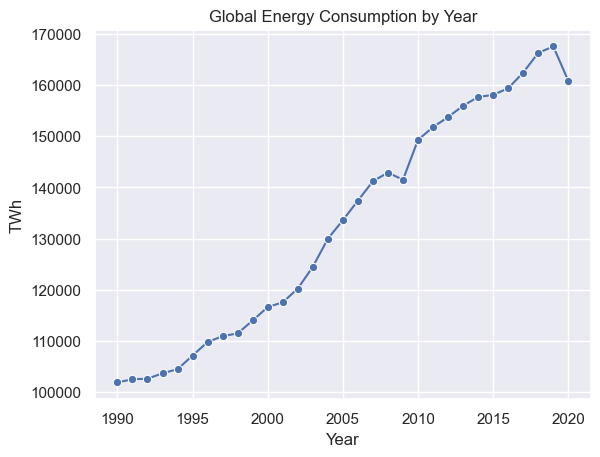

In [64]:
# Plot overall energy consumption by year
sns.set(style="darkgrid")
sns.lineplot(data=cont_consump, x='Year', y='World', marker='o')
plt.title("Global Energy Consumption by Year")
plt.xlabel("Year")
plt.ylabel("TWh")
plt.show()

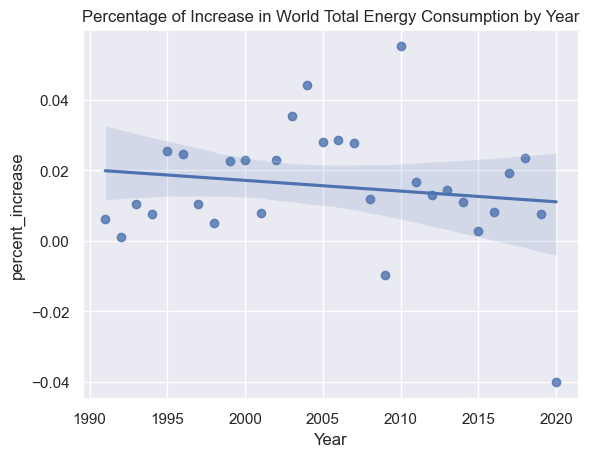

In [65]:
# Calculate the percentage increase or decrease in energy consumption compared to the previous year
world_df = cont_consump.loc[:,['Year', 'World']]
world_df['percent_increase'] = world_df['World'].pct_change()

# Plot the data
sns.regplot(x='Year', y='percent_increase', data=world_df)
plt.title('Percentage of Increase in World Total Energy Consumption by Year')
plt.show()

##### How has the energy consumption changed for Economic Aliances?

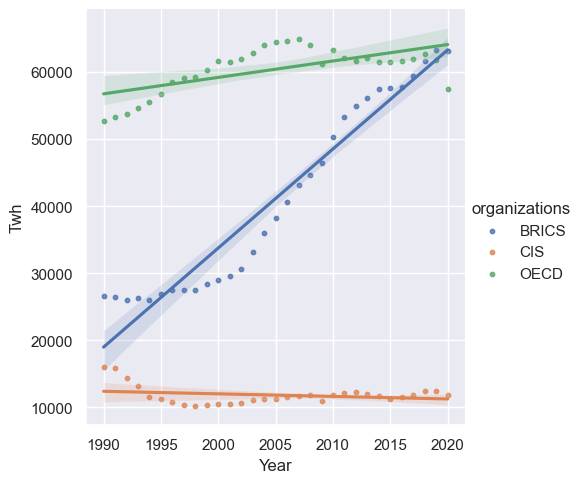

In [66]:
org_cols = ["BRICS", "CIS", "OECD"]
df = pd.melt(cont_consump, id_vars=["Year"], value_vars=org_cols, var_name="organizations", value_name="Twh")
df = df.dropna()

# Plot a regression line for each economic organization to identify trends in power consumption
# The trends of power consumption (TWh) of three economic organizations, BRICS, CIS, and OECD, are examined by year
sns.lmplot(data=df, x="Year", y="Twh", hue="organizations", scatter_kws={"s": 10})

##### Energy Consumption by countries over past 30 years

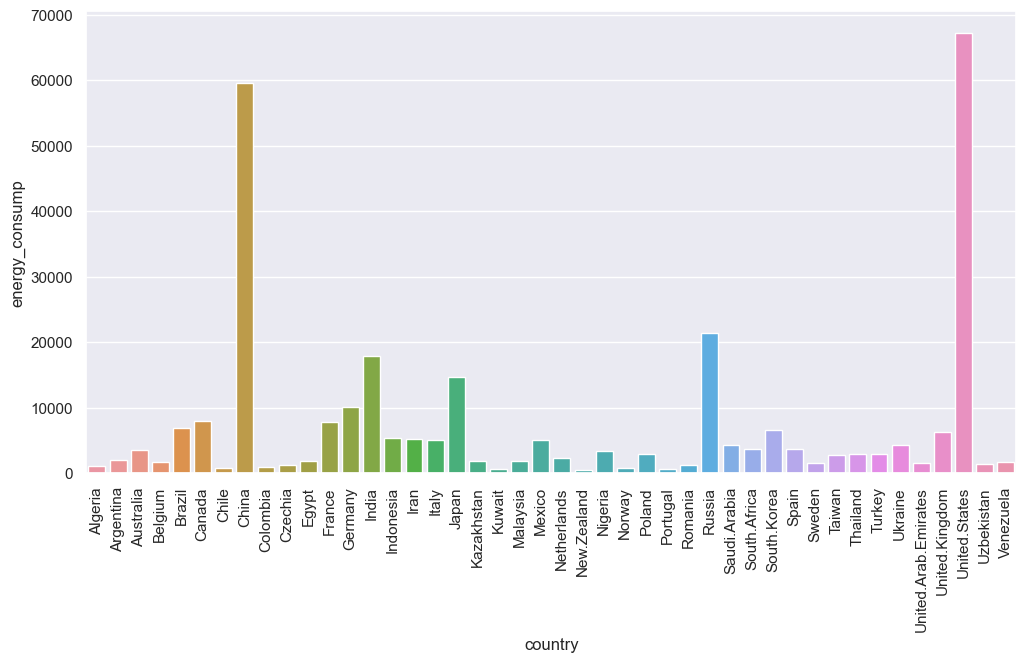

In [67]:
# Gather columns China to United Arab Emirates into a key-value pair
vars = country_consump.columns.tolist()
ctry_consump = pd.melt(country_consump, id_vars=['Year'], value_vars= vars[1:], var_name='country', value_name='energy_consump')
ctry_gup = ctry_consump.groupby('country')['energy_consump'].agg('sum').reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=ctry_gup, x='country', y='energy_consump')
plt.xticks(rotation=90)
plt.show()

##### 10 countries with the highest energy consumption

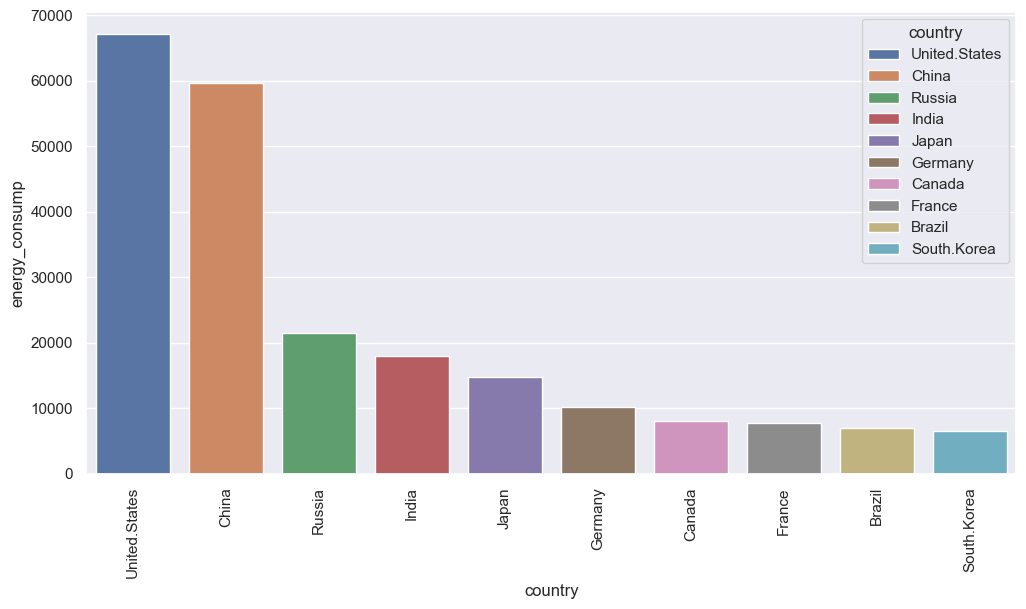

In [68]:
df = country_consump.melt(id_vars=['Year'], value_vars= vars[1:], var_name='country', value_name='energy_consump')

# Total energy consumption by country
df_sum = df.groupby('country').sum().reset_index()

# Top 10 Countries Extraction
top10 = df_sum.nlargest(10, 'energy_consump')

# Visualize as a bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='energy_consump', data=top10, hue = 'country', dodge = False)
plt.xticks(rotation=90)
plt.show()

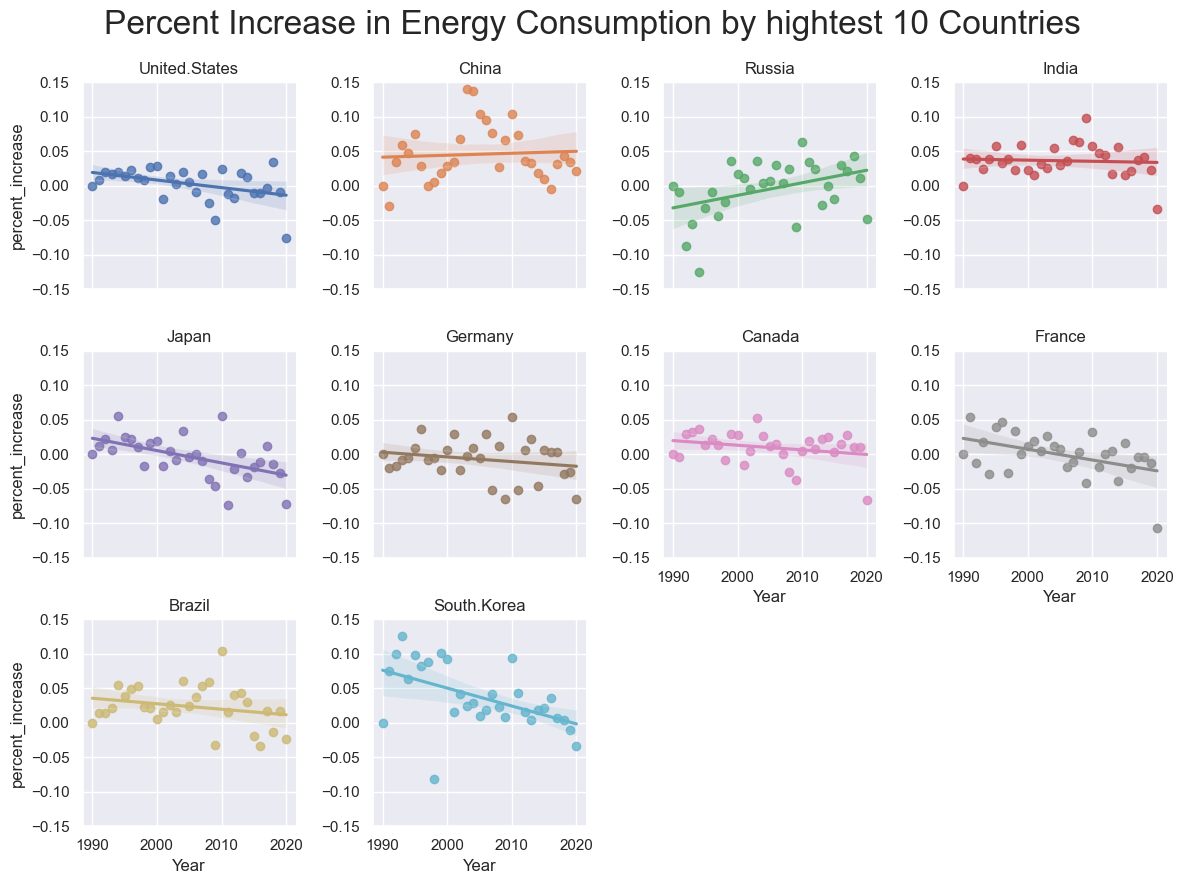

In [72]:
top10list = top10['country'].tolist()
# Calculate the percentage increase in total energy consumption per year in each of the 10 countries with the highest total energy consumption
melted_per = pd.melt(country_consump, id_vars=['Year'], value_vars=top10list, var_name='country', value_name='energy_consump')
melted_per['Percent Increase'] = (melted_per.groupby('country')['energy_consump'].apply(lambda x: x.pct_change()).replace([np.inf, -np.inf], np.nan)
.fillna(0))
melted_per = (melted_per.groupby('country').apply(lambda x: x.assign(percent_increase = (x['energy_consump'] - x['energy_consump'].shift(1, fill_value=x['energy_consump'].iloc[0]))/x['energy_consump'].shift(1, fill_value=x['energy_consump'].iloc[0]))).reset_index(drop=True))

# Plot the percentage increase in total energy consumption in the top 10 countries by year
g = sns.FacetGrid(data=melted_per, col='country', col_wrap=4, sharey=False, hue = 'country', ylim=(-0.15,0.15))
g.map_dataframe(sns.regplot, x='Year', y='percent_increase', marker='o')
g.set_titles(col_template='{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percent Increase in Energy Consumption by hightest 10 Countries', fontsize = 24)
plt.show()

&emsp; Except for Russia and China, it can be seen that the growth rate of energy consumption is decreasing.

#### Renewable sources vs Non-Renewable sources Energy Generation
##### Which energy source produces more energy?

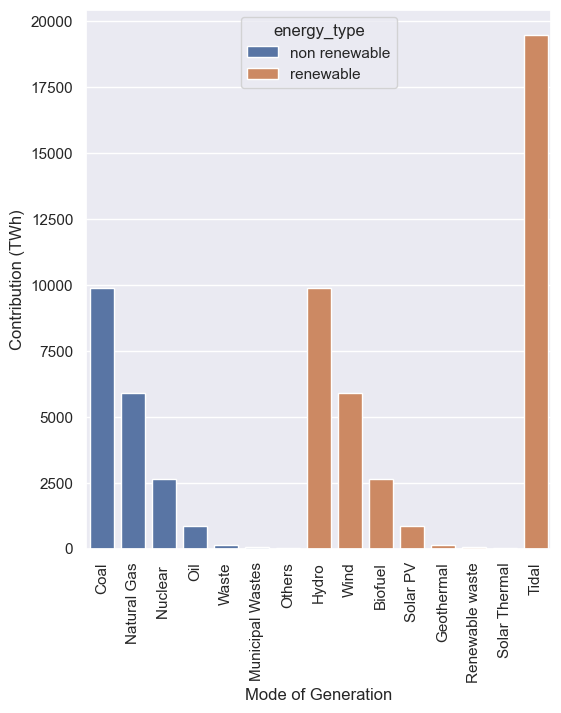

In [74]:
df = pd.concat([nonre_eng, re_eng_tot_gen])
df = df[df["Mode of Generation"] != "Total"]

# Plot by mode of generation
plt.figure(figsize=(6,7))
sns.barplot(x='Mode of Generation', y='Contribution (TWh)', hue='energy_type', data=df, dodge = False)
plt.xticks(rotation=90)
plt.show()

&emsp; Tidal energy is generated the most, followed by hydro energy. Coal is the non-renewable energy source that contributes the most to energy generation.

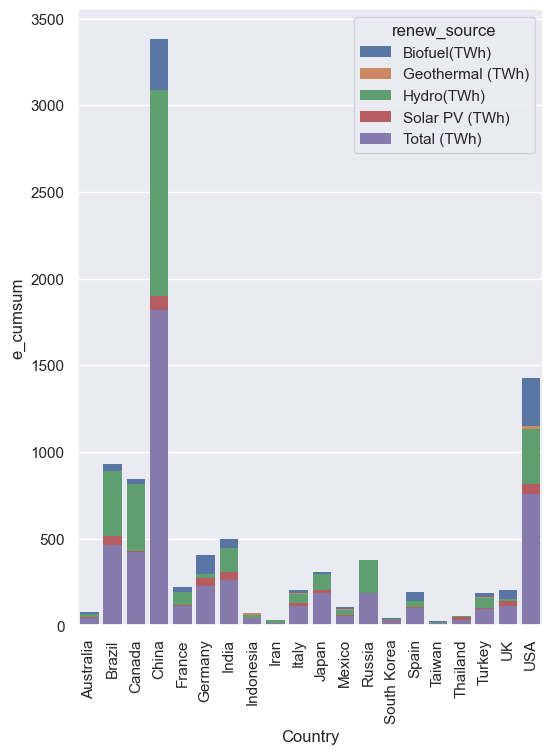

In [75]:
re_eng_countries_melt = pd.melt(re_eng_countries, id_vars='Country', var_name='renew_source', value_name='energy_Twh', 
                                value_vars=['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)', 'Total (TWh)'])

re_eng_countries_melt = pd.DataFrame(re_eng_countries_melt.groupby(['Country','renew_source']).energy_Twh.sum()).reset_index()
re_eng_countries_melt = re_eng_countries_melt.sort_values(by=['Country', 'renew_source'], ascending=False)
re_eng_countries_melt['e_cumsum'] = re_eng_countries_melt.groupby(['Country'])['energy_Twh'].cumsum()
re_eng_countries_melt = re_eng_countries_melt.sort_values(by=['Country', 'renew_source'], ascending=True)

plt.figure(figsize=(6,8))
sns.barplot(data=re_eng_countries_melt, x='Country', y='e_cumsum', hue='renew_source', dodge=False, edgecolor='None')
plt.xticks(rotation=90)
plt.show()

&emsp; China has the highest amount of renewable energy use, followed by the United States, Brazil, and Canada.

### YourName 3

In [ ]:
# Insert your code here

### YourName 4

In [ ]:
# Insert your code here